# Machine Learning Modelling

## Hotel Booking - Price Prediction

### Import Libraries

In [30]:
## General
import numpy as np
import pandas as pd

## EDA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colour_palette = sns.color_palette("hls", 8)

## Regression 
# import statsmodels.api as sm
# import statsmodels.formula.api as smf                 # for ols and logit
# from statsmodels.multivariate.pca import PCA

## Machine Learning
# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

### Pre-Processing

In [31]:
## Importing Data
data_hotel_bookings = pd.read_csv('../../Dataset/hotel_booking/hotel_bookings.csv')

## Understanding Data I
data_hotel_bookings.describe()
data_hotel_bookings


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [86]:
## Understanding Data II
print(data_hotel_bookings.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [32]:
## Check Missing Data
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [33]:
## Fill Missing Data

# For Children
data_hotel_bookings.children.fillna(0, inplace = True)

# For Country
data_hotel_bookings.country.fillna("Unknown", inplace = True)

# For Agent
data_hotel_bookings.loc[data_hotel_bookings.agent.isnull() == False, 'agent'] = 'Agent'
data_hotel_bookings.agent.fillna("No Agent", inplace = True)

# For Company 
data_hotel_bookings.loc[data_hotel_bookings.company.isnull() == False, 'company'] = 'Corporate'
data_hotel_bookings.company.fillna("No Company", inplace = True)

# Re-Confirm 
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

Series([], dtype: int64)

In [34]:
## Changing Data Types
data_hotel_bookings['children'] = data_hotel_bookings['children'].astype('int') 

In [35]:
## Adjust to suit Streaming Data - Hotel Reservation
data_hotel_bookings.loc[(data_hotel_bookings['meal'] == 'Undefined'), 'meal']= 'SC'
data_hotel_bookings.loc[(data_hotel_bookings['required_car_parking_spaces'] > 1), 'required_car_parking_spaces']= 1

In [36]:
## Separating Data
data_hotel_bookings_resort = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "Resort Hotel"]
data_hotel_bookings_city = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "City Hotel"]

In [37]:
## Selecting Columns in both Hotel Booking & Hotel Reservation
data_hotel_bookings_city.drop(['hotel', 'arrival_date_week_number', 'babies', 'country', 'distribution_channel', 
                               'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 
                               'days_in_waiting_list', 'customer_type', 'reservation_status', 'reservation_status_date'], 
                              axis = 1, inplace = True)

data_hotel_bookings_city.head()

C:\Users\KMwong\AppData\Local\Temp\ipykernel_14716\136513190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(['hotel', 'arrival_date_week_number', 'babies', 'country', 'distribution_channel',


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,adr,required_car_parking_spaces,total_of_special_requests
40060,0,6,2015,July,1,0,2,1,0,HB,Offline TA/TO,0,0,0,A,0.0,0,0
40061,1,88,2015,July,1,0,4,2,0,BB,Online TA,0,0,0,A,76.5,0,1
40062,1,65,2015,July,1,0,4,1,0,BB,Online TA,0,0,0,A,68.0,0,1
40063,1,92,2015,July,1,2,4,2,0,BB,Online TA,0,0,0,A,76.5,0,2
40064,1,100,2015,July,2,0,2,2,0,BB,Online TA,0,0,0,A,76.5,0,1


### Feature Engineering

In [90]:
# # create categories for the days_in_waiting_list column (1: 0-10days, 2: 11-20days, 3: 21-30days...)
# bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# data_hotel_bookings['days_in_waiting_list_category'] = pd.cut(data_hotel_bookings['days_in_waiting_list'], bins=bins, labels=labels)

# # print the result
# data_hotel_bookings[['days_in_waiting_list', 'days_in_waiting_list_category']].max()

days_in_waiting_list             391
days_in_waiting_list_category     15
dtype: int64

In [38]:
## Encoding

# OneHotEncoder (Run Once only)

# # perform one-hot encoding for the customer_type column
# customer_type_one_hot = pd.get_dummies(data_hotel_bookings['customer_type'], prefix='customer_type')
# # concatenate the one-hot encoded columns to the original dataset
# data_hotel_bookings = pd.concat([data_hotel_bookings, customer_type_one_hot], axis=1)
# # drop the original customer_type column
# data_hotel_bookings.drop('customer_type', axis=1, inplace=True)

# # perform one-hot encoding for the distribution_channel column
# distribution_channel_one_hot = pd.get_dummies(data_hotel_bookings['distribution_channel'], prefix='distribution_channel')
# # concatenate the one-hot encoded columns to the original dataset
# data_hotel_bookings = pd.concat([data_hotel_bookings, distribution_channel_one_hot], axis=1)
# # drop the original customer_type column
# data_hotel_bookings.drop('distribution_channel', axis=1, inplace=True)

# perform one-hot encoding for the market_segment column
market_segment_one_hot = pd.get_dummies(data_hotel_bookings_city['market_segment'], prefix='market_segment')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, market_segment_one_hot], axis=1)
# drop the original customer_type column
data_hotel_bookings_city.drop('market_segment', axis=1, inplace=True)


# LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

# # apply LabelEncoder to the reservation_status column ('Canceled': -1, 'No-Show': 0, 'Check-Out': 1)
# mapping_rs = {'Canceled': -1, 'No-Show': 0, 'Check-Out': 1}
# data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(mapping_rs)
# data_hotel_bookings['reservation_status'] = le.fit_transform(data_hotel_bookings['reservation_status'])
# data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(dict(zip(range(3), mapping_rs.values())))

# # apply LabelEncoder to the deposit_type column ('Non-Refund': -1, 'No Deposit': 0, 'Refundable': 1)
# mapping_dt = {'Non Refund': -1, 'No Deposit': 0, 'Refundable': 1}
# data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(mapping_dt)
# data_hotel_bookings['deposit_type'] = le.fit_transform(data_hotel_bookings['deposit_type'])
# data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(dict(zip(range(3), mapping_dt.values())))

# print the result
data_hotel_bookings_city

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,...,required_car_parking_spaces,total_of_special_requests,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined
40060,0,6,2015,July,1,0,2,1,0,HB,...,0,0,0,0,0,0,0,1,0,0
40061,1,88,2015,July,1,0,4,2,0,BB,...,0,1,0,0,0,0,0,0,1,0
40062,1,65,2015,July,1,0,4,1,0,BB,...,0,1,0,0,0,0,0,0,1,0
40063,1,92,2015,July,1,2,4,2,0,BB,...,0,2,0,0,0,0,0,0,1,0
40064,1,100,2015,July,2,0,2,2,0,BB,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,August,30,2,5,2,0,BB,...,0,0,0,0,0,0,0,1,0,0
119386,0,102,2017,August,31,2,5,3,0,BB,...,0,2,0,0,0,0,0,0,1,0
119387,0,34,2017,August,31,2,5,2,0,BB,...,0,4,0,0,0,0,0,0,1,0
119388,0,109,2017,August,31,2,5,2,0,BB,...,0,0,0,0,0,0,0,0,1,0


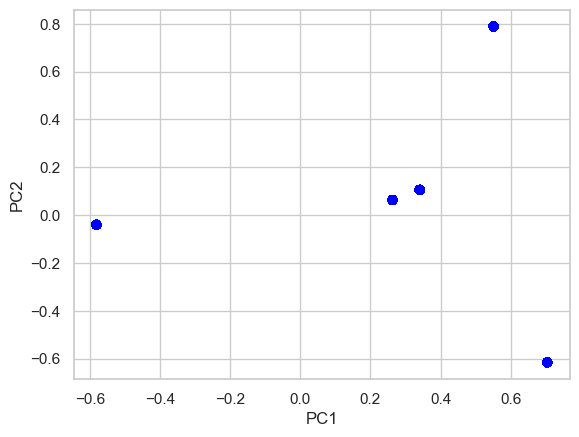

Explained variance ratios: [0.31705414 0.2476035  0.22108111 0.20000672 0.01425452]


In [39]:
## Principal Component Analysis (PCA)

# # Select variables for PCA
# X = data_hotel_bookings[['distribution_channel_Corporate', 'distribution_channel_Direct', 'distribution_channel_GDS', 'distribution_channel_TA/TO', 'distribution_channel_Undefined']]

# # Add cancellation status as target variable
# y = data_hotel_bookings['is_canceled']

# # Perform PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Create scatter plot of first two principal components
# colors = ['red' if x == 1 else 'blue' for x in y]
# plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()


# # Select variables for PCA
# X = data_hotel_bookings[['customer_type_Transient', 'customer_type_Transient-Party', 'customer_type_Group', 'customer_type_Contract']]

# # Add cancellation status as target variable
# y = data_hotel_bookings['is_canceled']

# # Perform PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Create scatter plot of first two principal components
# colors = ['red' if x == 1 else 'blue' for x in y]
# plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()


# Select variables for PCA
X = data_hotel_bookings_city[['market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'market_segment_Undefined']]

# Add adr as target variable
y = data_hotel_bookings_city['adr']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of first two principal components
colors = ['red' if x == 1 else 'blue' for x in y]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


X = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_var)

In [13]:
## Correlation Matrix
data_hotel_bookings_city.corr()

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,...,required_car_parking_spaces,total_of_special_requests,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined
is_canceled,1.000000,0.309242,-0.003004,-0.004331,-0.007343,0.048704,0.053054,-0.027089,-0.065840,0.166643,...,-0.133481,-0.293889,-0.021965,-0.050324,-0.081256,-0.142699,0.254432,0.011588,-0.085782,0.005934
lead_time,0.309242,1.000000,0.027876,0.014502,-0.023913,0.058361,0.115792,-0.053553,-0.107900,0.122511,...,-0.077939,-0.132450,-0.051950,-0.073968,-0.150010,-0.151769,0.356310,0.148088,-0.236576,-0.004898
arrival_date_year,-0.003004,0.027876,1.000000,-0.002910,0.034851,0.066234,0.067558,0.055555,-0.028661,-0.195255,...,-0.001367,0.135439,0.022693,-0.016954,-0.028647,0.025396,-0.144137,-0.140346,0.222208,-0.008433
arrival_date_day_of_month,-0.004331,0.014502,-0.002910,1.000000,0.000304,-0.011713,-0.001357,0.012839,-0.011979,-0.010891,...,0.003903,-0.001676,-0.000488,-0.009859,0.001670,-0.000200,0.030468,-0.012863,-0.011502,-0.006780
stays_in_weekend_nights,-0.007343,-0.023913,0.034851,0.000304,1.000000,0.219601,0.082130,0.037525,-0.080494,-0.038613,...,-0.024757,0.068762,0.018410,-0.046165,-0.088488,-0.009203,-0.063773,-0.038460,0.124211,-0.001675
stays_in_week_nights,0.048704,0.058361,0.066234,-0.011713,0.219601,1.000000,0.088253,0.037116,-0.094165,-0.050589,...,-0.038036,0.064186,0.012471,-0.058332,-0.092149,-0.014229,-0.098395,-0.002566,0.128041,-0.004078
adults,0.053054,0.115792,0.067558,-0.001357,0.082130,0.088253,1.000000,-0.005845,-0.167354,-0.038085,...,0.011099,0.155642,-0.091012,-0.065572,-0.242672,-0.011433,-0.050899,-0.075226,0.219372,0.006399
children,-0.027089,-0.053553,0.055555,0.012839,0.037525,0.037116,-0.005845,1.000000,-0.028869,-0.043777,...,0.055243,0.112702,-0.013438,-0.000625,-0.045526,0.074705,-0.111477,-0.102095,0.147431,-0.001233
is_repeated_guest,-0.065840,-0.107900,-0.028661,-0.011979,-0.080494,-0.094165,-0.167354,-0.028869,1.000000,0.268287,...,0.093661,0.018054,0.084693,0.191904,0.350698,0.010467,-0.032876,-0.041053,-0.121396,-0.000814
previous_cancellations,0.166643,0.122511,-0.195255,-0.010891,-0.038613,-0.050589,-0.038085,-0.043777,0.268287,1.000000,...,-0.003269,-0.076507,-0.003279,0.043013,0.073313,-0.039979,0.157421,0.014613,-0.145241,-0.000964


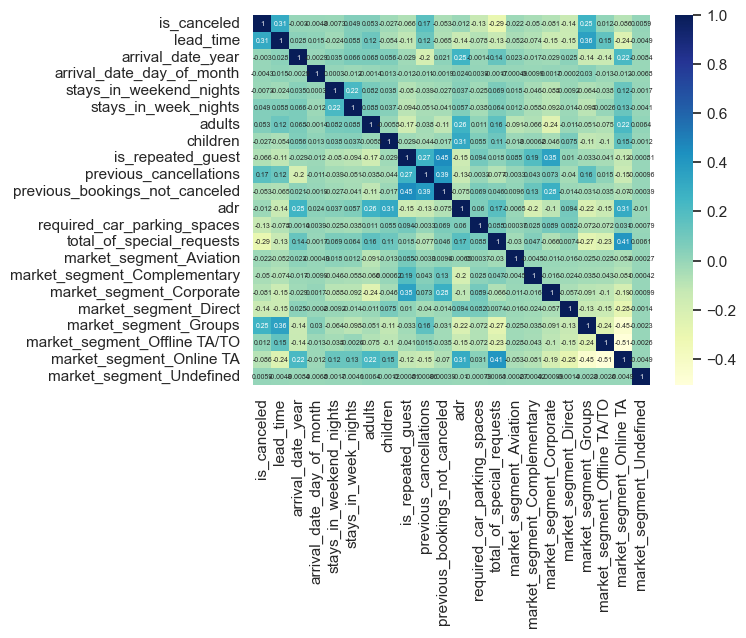

In [40]:
## Correlation Matrix Heatmap
sns.heatmap(data_hotel_bookings_city.corr(), cmap='YlGnBu', annot = True, annot_kws={"size":5})
plt.show()

Observations

High Positive Correlation:
- is_canceled & lead_time
- stays_in_weekend_nights & stays_in_week_nights
- is_repeated_guest & previous_bookings_not_cancelled
- previous_cancellations & previous_bookings_not_cancelled

Moderate Positive Correlation:
- previous_cancellations & is_repeated_guest
- previous_cancellations & is_cancelled
- previous_cancellations & lead_time
- adr & children
- adr & adults
- adr & arrival_date_year
- adr & total_of_special_requests

Moderate Negative Correlation:
- is_cancelled & total_of_special_requests
- previous_cancellations & arrival_date_year
- previous_cancellations & adr
- lead_time & adr

In [41]:
## Feature Importance
corr_adr = data_hotel_bookings_city.corr()["adr"]
corr_adr.abs().sort_values(ascending = False)

adr                               1.000000
children                          0.311955
market_segment_Online TA          0.305116
adults                            0.262895
arrival_date_year                 0.248757
market_segment_Groups             0.216164
market_segment_Complementary      0.195364
total_of_special_requests         0.174968
is_repeated_guest                 0.152716
market_segment_Offline TA/TO      0.145769
lead_time                         0.137240
previous_cancellations            0.129247
market_segment_Corporate          0.100622
market_segment_Direct             0.093771
previous_bookings_not_canceled    0.075280
required_car_parking_spaces       0.059501
stays_in_week_nights              0.057036
stays_in_weekend_nights           0.037020
arrival_date_day_of_month         0.023913
is_canceled                       0.011965
market_segment_Undefined          0.010399
market_segment_Aviation           0.006481
Name: adr, dtype: float64

Observations

Top 7 Feature Selection By Importance
1. children
2. adults
3. arrival_date_year
4. total_of_special_requests
5. is_repeated_guest
6. lead_time
7. previous_cancellations

In [42]:
## Selecting Top 7 Features for Model Building
data_hotel_bookings_city_feature = data_hotel_bookings_city[['adr', 'children', 'adults', 'arrival_date_year', 'total_of_special_requests', 'is_repeated_guest', 'lead_time', 'previous_cancellations']]
data_hotel_bookings_city_feature.drop(index = [row for row in data_hotel_bookings_city_feature.index if 0 >= data_hotel_bookings_city_feature.loc[row, 'adr']], inplace = True)
data_hotel_bookings_city_feature.head()

C:\Users\KMwong\AppData\Local\Temp\ipykernel_14716\1707914493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city_feature.drop(index = [row for row in data_hotel_bookings_city_feature.index if 0 >= data_hotel_bookings_city_feature.loc[row, 'adr']], inplace = True)


,adr,children,adults,arrival_date_year,total_of_special_requests,is_repeated_guest,lead_time,previous_cancellations
40061,76.5,0,2,2015,1,0,88,0
40062,68.0,0,1,2015,1,0,65,0
40063,76.5,0,2,2015,2,0,92,0
40064,76.5,0,2,2015,1,0,100,0
40065,76.5,0,2,2015,1,0,79,0


### Time Series Forecasting

<AxesSubplot:xlabel='arrival_date_year'>

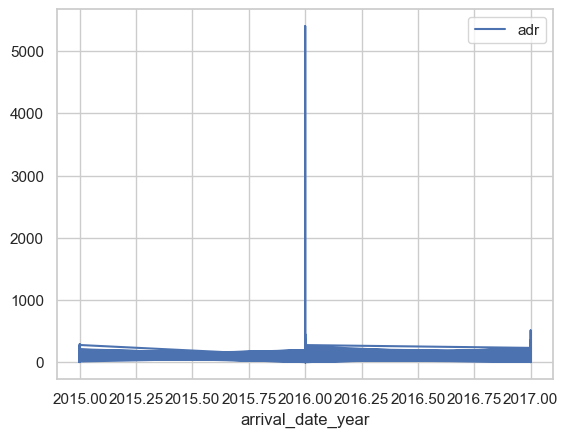

In [43]:
# Simple TS
data_hotel_bookings_city_ts = data_hotel_bookings_city_feature[['adr', 'arrival_date_year']]
# data_hotel_bookings_city_ts['arrival_date_year'] = pd.to_datetime(data_hotel_bookings_city_ts['arrival_date_year'])
data_hotel_bookings_city_ts.set_index('arrival_date_year', inplace = True)
data_hotel_bookings_city_ts.plot()

# Looks Bad

### Model Selection

In [44]:
## Evaluation Function (with different Metrics)
def evaluation(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))         # Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
    # print("Specificity: " (y_test, y_pred))                   # Proportion of Predicted No out of Actual No: (TN) / (FP + TN)
    print("Precision: ", precision_score(y_test, y_pred))       # Proportion of Actual Yes out of Predicted Yes: (TP) / (TP + FP)
    print("Sensitivity/Recall: ", recall_score(y_test, y_pred)) # Proportion of Predicted Yes out of Actual Yes: (TP) / (TP + FN)
    print("F1 Score: ", f1_score(y_test, y_pred))               # Balanced Index Between Precision & Sensitivity: (2 * Precision * Sensitivity) / (Precision + Sensitivity)
    print("Classification report: \n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title('Confusion Matrix For Given Prediction')
    plt.show()

In [45]:
## Splitting Data (80:20)
x = data_hotel_bookings_city_feature.drop(columns = 'adr')
# y = data_hotel_bookings_city_feature.adr
y = data_hotel_bookings_city_feature.adr * 100
y = y.astype('int') 

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((62497, 7), (15625, 7))

In [ ]:
## Model : Linear Regression

lnr = LinearRegression()
lnr_model = lgr.fit(x_train, y_train)
lnr_y_pred = lnr_model.predict(x_test)
evaluation(y_train, lnr_model.predict(x_train))

In [ ]:
## Model : Logistic Regression

lgr = LogisticRegression()
lgr_model = lgr.fit(x_train, y_train)
lgr_y_pred = lgr_model.predict(x_test)
evaluation(y_train, lgr_model.predict(x_train))

In [20]:
## Model : Naive Bayes (using GNB Technique)
# Assumes each parameter (Feature) has an independent capacity of predicting output variable

gnb = GaussianNB()
gnb_model = gnb.fit(x_train, y_train)
gnb_y_pred = gnb_model.predict(x_test)
evaluation(y_train, gnb_model.predict(x_train))

In [ ]:
## Model : K-Nearest Neighbours

knn = KNeighborsClassifier()
knn_model = knn.fit(x_train, y_train)
knn_y_pred = knn_model.predict(x_test)
evaluation(y_train, knn_model.predict(x_train))

In [25]:
## Model : Random Forest Classifier
# Combines output of multiple decision trees to reach a single result

rf = RandomForestClassifier()
rf_model = rf.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)
evaluation(y_train, rf_model.predict(x_train))

In [27]:
## Model : Decision Tree Classifier 
# Non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks

dt = DecisionTreeClassifier()
dt_model = dt.fit(x_train, y_train)
dt_y_pred = dt_model.predict(x_test)
evaluation(y_train, dt_model.predict(x_train))

In [ ]:
## Model : Extra Trees 
# Meta estimator that fits a number of randomized decision trees and uses averaging to improve the predictive accuracy and control over-fitting.

et = ExtraTreesClassifier()
et_model = et.fit(x_train, y_train)
et_y_pred = et_model.predict(x_test)
evaluation(y_train, et_model.predict(x_train))

In [ ]:
## Model : Ada Boost
# Meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier 
# on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers 
# focus more on difficult cases.

ada = AdaBoostClassifier(base_estimator = dt)
ada_model = ada.fit(x_train, y_train)
ada_y_pred = ada_model.predict(x_test)
evaluation(y_train, ada_model.predict(x_train))

In [ ]:
## Model : Gradient Boosting
# Functional gradient algorithm that repeatedly selects a function that leads in the direction of a weak hypothesis or 
# negative gradient so that it can minimize a loss function.

gb = GradientBoostingClassifier()
gb_model = gb.fit(x_train, y_train)
gb_y_pred = gb_model.predict(x_test)
evaluation(y_train, gb_model.predict(x_train))

Model Comparison

Ranking Models By Performance
1. 
2.
3.
4.
5.
6.
7.
8.

In [22]:
# # Model : Logistic Regression

# X = data_hotel_bookings.drop('is_canceled', axis=1)
# y = data_hotel_bookings['is_canceled']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a logistic regression model
# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Make predictions on the testing set
# y_pred = model.predict(X_test)

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")